Firstly some standard imports.

In [1]:
import tensorflow as tf
import keras 
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import sys
import random

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instead of loading the data manually, Keras' ImageDataGenerators will be used to do all the work instead. 

The training set is fed into the model after being randomly cropped and flipped but the test set will be fed as-is. The augmentations will lead to the model being scale invariant; critical if the regional classification is to work.

In [2]:
from keras.preprocessing.image import ImageDataGenerator#
image_size = 1024
input_size = 331
train_dir = 'Neuron Cy5 Train Data'
test_dir = 'Neuron Cy5 Test Data'

# Create generator with augmentation for training
train_gen = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True,
                               samplewise_center=True,
                               samplewise_std_normalization=True).flow_from_directory(train_dir, 
                                                                                      target_size=(image_size,image_size),
                                                                                      color_mode='grayscale',
                                                                                      class_mode='categorical',
                                                                                      batch_size=16,
                                                                                      shuffle=True)
# Create generator with no augmentation for testing
test_gen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True).flow_from_directory(test_dir, 
                                                                                     target_size=(input_size,input_size),
                                                                                     color_mode='grayscale',
                                                                                     class_mode='categorical',
                                                                                     batch_size=16,
                                                                                     shuffle=True)
classes = dict((v, k) for k, v in train_gen.class_indices.items())
num_classes = len(classes)

Found 692 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [3]:
def rand_crop(img):
    # Select size of crop
    h = random.randint(input_size, image_size) 
    # Select lower left corner for crop
    cx = random.randint(0, image_size-h)
    cy = random.randint(0, image_size-h)
    # Crop and resize image to input_size
    cropped_img = img[cx:cx+h,cy:cy+h,:]
    return cv2.resize(cropped_img, (input_size,input_size))

In [4]:
def crop_gen(batch_gen):
    '''Generator of cropped images.
    Takes a generator as it's input and returns cropped versions of the generators output.    
    '''
    while True:
        batch_x, batch_y = next(batch_gen)
        batch_crops = np.zeros((batch_x.shape[0], input_size, input_size, 1))
        for i in range(batch_x.shape[0]):
            batch_crops[i,...,0] = rand_crop(batch_x[i])
        yield (batch_crops, batch_y)

The pretrained model to be used is the VGG19. The original Dense layers are removed and replaced with three Dense Layers, two with 2048 nodes and the final one with 2 for classification

As the images are being fed in as grayscale and hence have only one channel, the standard weights in the first Convolution layer of the VGG19 must be summed over the channel dimension to produce filters with shape (3, 3, 1) as opposed to (3, 3, 3).  Then all layers apart from the final Dense layers are frozen and the model is trained for 10 epochs using the Adam optimizer with a slightly reduced learning rate.

The F1 metric was removed in Keras 2.0 so has to be defined before it can be used during training.

In [5]:
from keras import backend as K
    
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications import VGG19
from tensorflow.python.keras.layers import GlobalMaxPooling2D, Dense
from tensorflow.python.keras.optimizers import Adam

# Create a VGG19 architecture
pretrained_model = VGG19(include_top=False,
                         pooling='none',
                         input_shape=(input_size, input_size, 3),
                         weights='imagenet')
x = GlobalMaxPooling2D()(pretrained_model.output)
x = Dense(2048, activation='relu')(x)
x = Dense(2048, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
vgg19_model = Model(pretrained_model.input, output)

# Create new model with modified config which accepts the input shape: [input_size, input_size, 1]
cfg = vgg19_model.get_config()
cfg['layers'][0]['config']['batch_input_shape'] = (None, input_size, input_size, 1)
model = Model.from_config(cfg)

# Set the model weights to that of the pretrained VGG19
# and freeze all layers except the final Dense layers.
for i, layer in enumerate(model.layers):
    if i == 1:
        new_weights = np.reshape(vgg19_model.layers[i].get_weights()[0].sum(axis=2),(3,3,1,64))
        model.set_weights([new_weights])
        layer.trainable = False
    elif len(model.layers) - i > 3: # Freeze all but last 3 layers
        layer.trainable = False
        layer.set_weights(vgg19_model.layers[i].get_weights())
    else:
        layer.trainable = True 
        layer.set_weights(vgg19_model.layers[i].get_weights())

# Compile the model with Adam optimizer, binary crossentropy loss and f1 score as the metric
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # 10x smaller than standard
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[f1])
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 331, 331, 1)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 331, 331, 64)      640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 331, 331, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 165, 165, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 165, 165, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 165, 165, 128)     147584    
_________________________________________________________________
block2_pool

In [7]:
# Train the model
history = model.fit_generator(crop_gen(train_gen),
                              epochs=5,
                              steps_per_epoch=4*len(train_gen), # Effectively 1 run through every possibility of reflected data
                              validation_data=test_gen,
                              validation_steps=len(test_gen), 
                              verbose=1)

Epoch 1/5
176/176 [==============================] - 177s 1s/step - loss: 0.4075 - f1: 0.8153 - val_loss: 0.2344 - val_f1: 0.9000
Epoch 2/5
176/176 [==============================] - 168s 956ms/step - loss: 0.2271 - f1: 0.9105 - val_loss: 0.1338 - val_f1: 0.9600
Epoch 3/5
176/176 [==============================] - 168s 953ms/step - loss: 0.2315 - f1: 0.9080 - val_loss: 0.1834 - val_f1: 0.8900
Epoch 4/5
176/176 [==============================] - 168s 957ms/step - loss: 0.2336 - f1: 0.9070 - val_loss: 0.2531 - val_f1: 0.8900
Epoch 5/5
176/176 [==============================] - 168s 956ms/step - loss: 0.1936 - f1: 0.9190 - val_loss: 0.1685 - val_f1: 0.9600


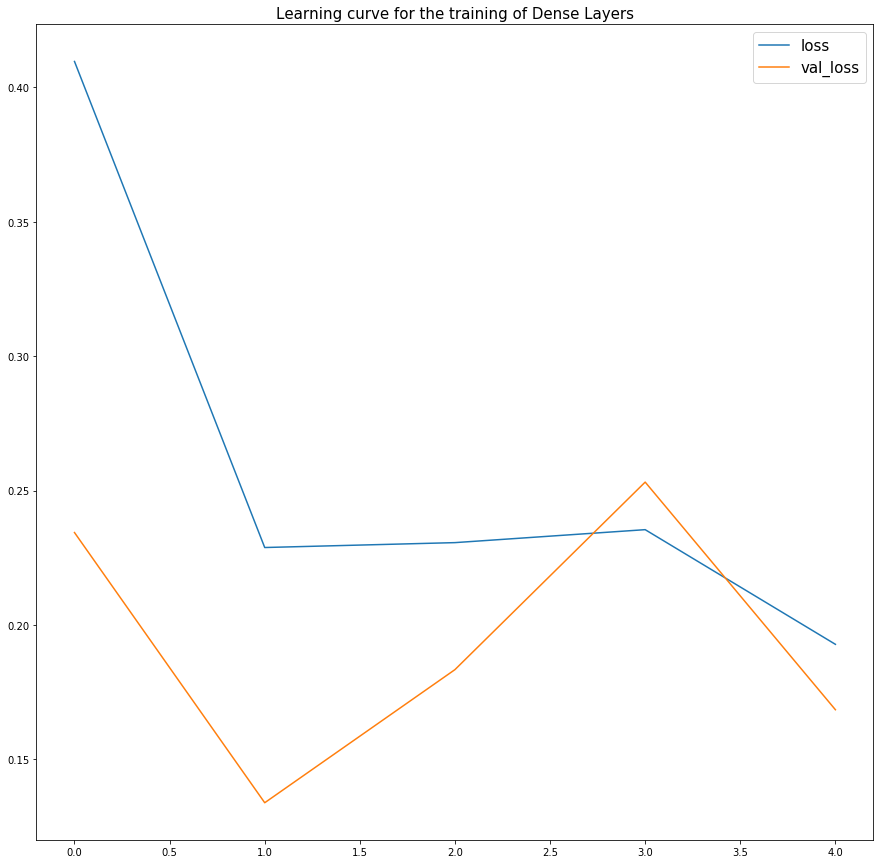

Best test F1 score: 0.9599999809265136


In [8]:
# Plot learning curve
plt.figure(figsize=(15,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'], loc='upper right',prop={'size': 15});
plt.title('Learning curve for the training of Dense Layers', fontsize=15)
plt.show()
print('Best test F1 score: ' + max(history.history['val_f1']).astype(str))

To further increase model performance, the entire model is unfrozen and trained for a further 10 epochs. This time, however, the learning rate used in the Adam optimiser is dropped by a factor of 20.

ModelCheckpoint is used to ensure that only the weights of the best model are saved. This becomes particularly useful if the model begins to overfit towards the end of the training process.

In [9]:
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint

# Unfreeze all weights
for layer in model.layers:
    layer.trainable = True
    
# Recompile with Adam optimizer with smaller initial learning rate
adam_fine = Adam(lr=0.00002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) # 50x smaller than standard
checkpoint = ModelCheckpoint('VGG19_weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)

model.compile(optimizer=adam_fine, loss='binary_crossentropy', metrics=[f1])

In [10]:
# Train the model
history2 = model.fit_generator(crop_gen(train_gen),
                              epochs=10,
                              steps_per_epoch=4*len(train_gen), #effectively 1 run through every possibility of reflected data
                              validation_data=test_gen,
                              validation_steps=len(test_gen), 
                              callbacks =[checkpoint],
                              verbose=1)

Epoch 1/10
176/176 [==============================] - 227s 1s/step - loss: 0.3313 - f1: 0.8682 - val_loss: 0.1050 - val_f1: 0.9400
Epoch 2/10
176/176 [==============================] - 218s 1s/step - loss: 0.1683 - f1: 0.9347 - val_loss: 0.3335 - val_f1: 0.8700
Epoch 3/10
176/176 [==============================] - 218s 1s/step - loss: 0.1334 - f1: 0.9510 - val_loss: 0.0596 - val_f1: 0.9800
Epoch 4/10
176/176 [==============================] - 218s 1s/step - loss: 0.1233 - f1: 0.9549 - val_loss: 0.0717 - val_f1: 0.9800
Epoch 5/10
176/176 [==============================] - 218s 1s/step - loss: 0.1053 - f1: 0.9606 - val_loss: 0.1743 - val_f1: 0.9600
Epoch 6/10
176/176 [==============================] - 218s 1s/step - loss: 0.1269 - f1: 0.9528 - val_loss: 0.0483 - val_f1: 0.9800
Epoch 7/10
176/176 [==============================] - 217s 1s/step - loss: 0.0897 - f1: 0.9673 - val_loss: 0.2607 - val_f1: 0.9300
Epoch 8/10
176/176 [==============================] - 218s 1s/step - loss: 0.0941 -

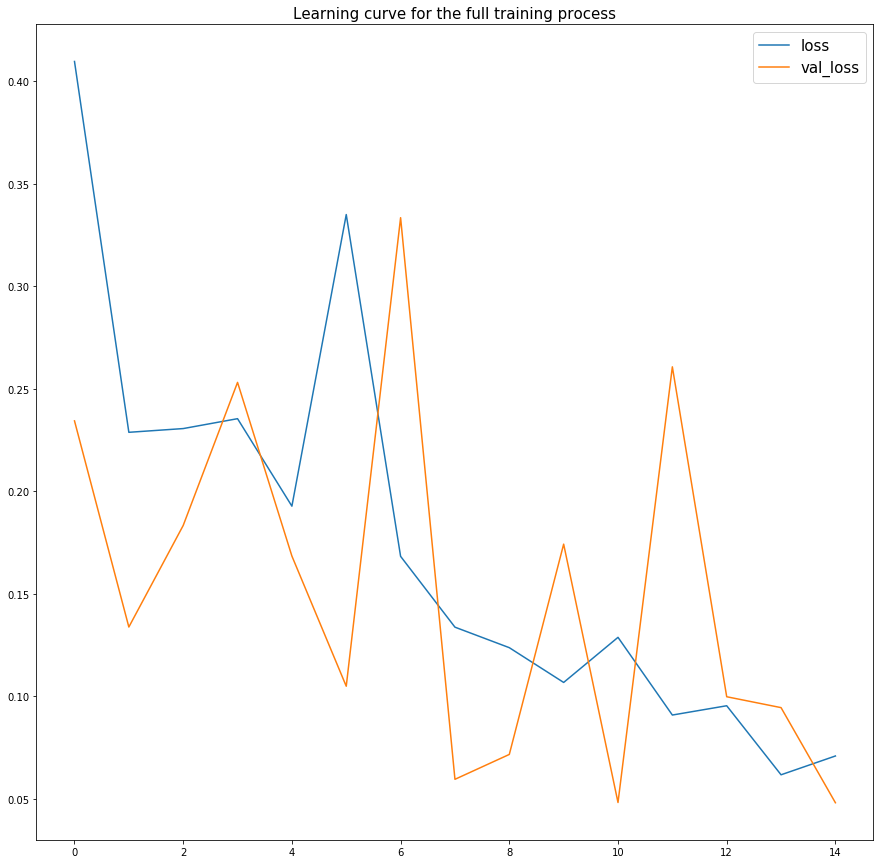

Best test F1 score: 0.9799999880790711


In [11]:
# Plot learning curve for the whole training process
full_history = dict()
for key in history.history.keys():
    full_history[key] = history.history[key]+history2.history[key]

plt.figure(figsize=(15,15))
plt.plot(full_history['loss'])
plt.plot(full_history['val_loss'])
plt.legend(['loss','val_loss'], loc='upper right',prop={'size': 15});
plt.title('Learning curve for the full training process', fontsize=15)
plt.show()
print('Best test F1 score: ' + max(full_history['val_f1']).astype(str))